In [1]:
!pip install torch  
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv;
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv

--2023-06-09 02:48:23--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv
Resolving ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)... 52.218.110.112, 52.218.42.8, 3.5.67.15, ...
Connecting to ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)|52.218.110.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93472103 (89M) [text/csv]
Saving to: ‘webis_train.csv.1’

webis_train.csv.1   100%[===================>]  89.14M  55.7MB/s    in 1.6s    

2023-06-09 02:48:24 (55.7 MB/s) - ‘webis_train.csv.1’ saved [93472103/93472103]

--2023-06-09 02:48:25--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv
Resolving ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)... 52.218.110.112, 52.218.42.8, 3.5.67.15, ...
Connecting to ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)|52.218.110.112|:443... c

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [5]:
train_df = pd.read_csv('webis_train.csv')
test_df = pd.read_csv('webis_test.csv')

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_imbalace_weight(df, labels):
  negative_class = df[labels].value_counts()[0]
  positive_class = df[labels].value_counts()[1]
  return [1.0, negative_class/positive_class]

In [8]:
weights = get_imbalace_weight(train_df, 'truthClass')
class_weight = torch.FloatTensor(weights).to(device)

# Inital Hyper-Parameter

In [9]:
from datetime import datetime
parameters = {
    'time' : str(datetime.now()).replace(" ", "_"),
    'config' : 'roberta-base',
    'learning_rate' : 1e-6,
    'epochs' : 15,
    'max_len' : 75,
    'batch_size' : 16,
    'dropout' : 0.15,
    'hidden_size' : 768
}

In [10]:
from sentence_transformers import SentenceTransformer

# Iitial Dataset

In [11]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [12]:
class ClickBaitDataset(Dataset):
  def __init__(self, mode, df, headline, paragraph, label, args):
    assert ['train', 'valid', 'test']
    self.mode = mode
    if self.mode != 'test':
      self.labels = list(df[label])
    self.headlines = list(df[headline])
    self.paragraphs = list(df[paragraph])
    self.tokenizer = AutoTokenizer.from_pretrained(args['config'])
    self.max_len = args['max_len']
  
  def __len__(self):
    return len(self.headlines)

  # transform texts to its number
  def tokenize(self, input_text):
    token_result = self.tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=self.max_len, 
      padding="max_length",
      truncation=True,
      return_token_type_ids=True
    )
    return torch.tensor(token_result['input_ids'], dtype=torch.long), torch.tensor(token_result['attention_mask'], dtype=torch.long), torch.tensor(token_result['token_type_ids'], dtype=torch.long)

  def __getitem__(self, index) :
    headline = str(self.headlines[index])
    paragraph = str(self.paragraphs[index])

    headline_ids, headline_mask, headline_token_type_ids = self.tokenize(headline)
    paragraph_ids, paragraph_mask, paragraph_token_type_ids = self.tokenize(paragraph)

    if self.mode == 'test':
      return headline_ids, headline_mask, headline_token_type_ids, paragraph_ids, paragraph_mask, paragraph_token_type_ids
    else:
      label = 0
      label_ = 1
      if self.labels[index] == 'clickbait':
        label = 1
        label_ = -1
      return headline_ids, headline_mask, headline_token_type_ids, paragraph_ids, paragraph_mask, paragraph_token_type_ids, torch.tensor(label, dtype=torch.long), torch.tensor(label_, dtype=torch.long)

In [13]:
from sklearn.model_selection import train_test_split
train_df_, valid_df_ = train_test_split(train_df, test_size=0.20, random_state=42, stratify=train_df['truthClass'])

In [14]:
train_ds = ClickBaitDataset('train', train_df_, 'postText', 'targetParagraphs', 'truthClass', parameters)
valid_ds = ClickBaitDataset('valid', valid_df_, 'postText', 'targetParagraphs', 'truthClass', parameters)
test_ds = ClickBaitDataset('test', test_df, 'postText', 'targetParagraphs', 'truthClass', parameters)

In [15]:
train_loader = DataLoader(train_ds, batch_size=parameters['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=parameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [16]:
train_df

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19533,19533,['media/photo_804240867972304896.jpg'],Brazil soccer team and pilot's final interview...,804250183642976256,"['CNBC', 'msnbc', 'NBC NEWS', 'TODAY', 'xfinity']",['Watch Live:\xa0Joe Biden Honored on Senate F...,"NBC News Video See Brazil Soccer Team, Pilot’s...",Thu Dec 01 09:06:00 +0000 2016,NaN,NBC News,"[0.33333333330000003, 0.0, 1.0, 0.666666666600...",0.400000,no-clickbait,0.333333,0.000000
19534,19534,[],😱😱😱😱😱😱😱😱😱😱😱😱😱😱,804156272086020096,"['Instagram/madonna', 'Speaker Ryan Retreats o...",['On November 30 Politico reported that Eric T...,Politico Scoop: Eric Trump Killed Two Deer,Thu Dec 01 02:52:50 +0000 2016,Politico Scoop: Eric Trump Killed Two Deer,Politico Scoop: Eric Trump Killed Two Deer,"[1.0, 1.0, 1.0, 1.0, 0.0]",0.800000,clickbait,1.000000,1.000000
19535,19535,[],Frenchs Forest high school may have to make wa...,804149798651588608,"[""An artist's impression of the proposed new t...","[""The Forest High School on Sydney's northern ...",Frenchs Forest high school may relocate to mak...,Thu Dec 01 02:27:07 +0000 2016,"frenchs forest, northern beaches, sydney, rede...",The Forest High School on Sydney's northern be...,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000
19536,19536,['media/photo_804133521023324160.jpg'],Oh Jeff… #bruh,804134698729385984,['Jeff Fisher May Think Danny Woodhead Still P...,"[""NFL coaches have a lot of information to rem...",Los Angeles Rams Jeff Fisher May Think Danny W...,Thu Dec 01 01:27:06 +0000 2016,"Humor, Football, NFL, NFC West, Los Angeles Ra...","Los Angeles Rams news, rumors, scores, schedul...","[0.0, 0.0, 0.0, 0.0, 0.66666

# Create Model

In [17]:
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel, RobertaModel

In [18]:
class SiameseNetwork(RobertaPreTrainedModel):
  def __init__(self, config, args):
    super(SiameseNetwork, self).__init__(config)
    self.roberta = RobertaModel(config)
    self.init_weights()
    self.dropout = nn.Dropout(args['dropout'])
    hidden_size = args['hidden_size']
    self.batch_norm = nn.BatchNorm1d(hidden_size)
    self.fc1 = nn.Linear(hidden_size, 256)
    self.classifier = nn.Sequential(
      nn.Linear(hidden_size, 256),
      self.dropout,
      nn.LeakyReLU(inplace=True),
      nn.Linear(256,2)
    )
  def forward(self, headline, labels=None):
    out = self.roberta(input_ids = headline[0], attention_mask = headline[1], token_type_ids = headline[2])[1]
    out = self.batch_norm(out)
    logits = self.classifier(out)
    if labels is not None:
      loss_fct2 = torch.nn.CrossEntropyLoss(weight=class_weight)
      loss = loss_fct2(logits, labels)
      return logits, loss
    return logits

In [19]:
data = next(iter(train_loader))
head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
headline = [head_ids, head_masks, head_token_type_ids]
paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]

In [20]:
model = SiameseNetwork.from_pretrained(parameters['config'], parameters).to(device)
output, loss = model(
  headline, labels
)

Some weights of the model checkpoint at roberta-base were not used when initializing SiameseNetwork: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing SiameseNetwork from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SiameseNetwork from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SiameseNetwork were not initialized from the model checkpoint at roberta-base and are newly initialized: ['batch_norm.running_var', 'roberta.pooler.dense.weight', 'classifier.3.bias', 'batch_norm.weight', 'batch_norm.running_mean', 'batch_norm.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'classifi

In [21]:
output

tensor([[ 0.0180, -0.0015],
        [ 0.0157,  0.0014],
        [ 0.0171,  0.0013],
        [ 0.0170,  0.0034],
        [ 0.0153,  0.0018],
        [ 0.0171, -0.0009],
        [ 0.0162,  0.0009],
        [ 0.0146, -0.0006],
        [ 0.0171,  0.0016],
        [ 0.0151,  0.0024],
        [ 0.0176,  0.0014],
        [ 0.0152,  0.0023],
        [ 0.0173, -0.0019],
        [ 0.0181,  0.0005],
        [ 0.0168, -0.0001],
        [ 0.0163,  0.0011]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
loss

tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward0>)

# Functions

In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [24]:
def get_pred(logits):
  _, preds = torch.max(logits, dim=1)
  return preds

In [25]:
  def cal_metrics(pred, ans):
    ans = ans.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    acc = accuracy_score(ans, pred)
    f1 = f1_score(ans, pred, zero_division=1)
    recall = recall_score(ans, pred)
    precision = precision_score(ans, pred)
    return acc, f1, recall, precision
    # return acc

In [26]:
# save model to path
def save_checkpoint(save_path, model):
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):    
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  
  model.load_state_dict(state_dict)
  return model

In [27]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Inital Model

In [28]:
transformers.logging.set_verbosity_error() # close the warning message
model = SiameseNetwork.from_pretrained(parameters['config'], parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

# Evaluate Model

In [29]:
def evaluate(model, data_loader, device):
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
      headline = [head_ids, head_masks, head_token_type_ids]
      paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]
      logits, loss = model(headline, labels)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
      # acc = cal_metrics(get_pred(logits), labels)
      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count += 1
    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count
  return val_loss, val_acc, val_f1, val_rec, val_prec
  # return val_loss, val_acc

# Train Model

In [30]:
import torch.optim as optim

In [31]:
# Start training
import time
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}
lowest_loss = 1000.0
highest_acc = 0.0
for epoch in range(parameters['epochs']):
  st_time = time.time()
  train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  model.train()
  for data in train_loader:
    head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
    headline = [head_ids, head_masks, head_token_type_ids]
    paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]
    logits, loss = model(headline, labels)
    acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
    train_loss += loss.item()
    train_acc += acc
    train_f1 += f1
    train_rec += rec
    train_prec += prec

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    step_count += 1

  # evaluate the model performace on val data after finishing an epoch training 
  val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, valid_loader, device)

  train_loss = train_loss / step_count
  train_acc = train_acc / step_count
  train_f1 = train_f1 / step_count
  train_rec = train_rec / step_count
  train_prec = train_prec / step_count

  print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
  print('         loss     acc     f1      rec    prec')
  print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
  print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

  # record training metrics of each training epoch
  record['train_loss'].append(train_loss)
  record['train_acc'].append(train_acc)
  record['train_f1'].append(train_f1)
  record['train_rec'].append(train_rec)
  record['train_prec'].append(train_prec)

  record['val_loss'].append(val_loss)
  record['val_acc'].append(val_acc)
  record['val_f1'].append(val_f1)
  record['val_rec'].append(val_rec)
  record['val_prec'].append(val_prec)
  # save best accuracy
  the_current_loss = val_loss
  the_current_acc = val_acc
  if the_current_loss <= lowest_loss:
    lowest_loss = the_current_loss
    save_checkpoint('./clickbait_loss.pt' , model)
  if highest_acc <= the_current_acc:
    highest_acc = the_current_acc
    save_checkpoint('./clickbait_acc.pt', model)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 1] cost time: 247.8143 s
         loss     acc     f1      rec    prec
train | 0.6194, 0.6219, 0.4935, 0.7951, 0.3843
val  | 0.4729, 0.7656, 0.6232, 0.8805, 0.5083

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 2] cost time: 245.8281 s
         loss     acc     f1      rec    prec
train | 0.4472, 0.7807, 0.6309, 0.8517, 0.5332
val  | 0.4031, 0.8089, 0.6630, 0.8586, 0.5712

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 3] cost time: 253.9526 s
         loss     acc     f1      rec    prec
train | 0.4024, 0.8144, 0.6675, 0.8578, 0.5840
val  | 0.3912, 0.8329, 0.6753, 0.8066, 0.6182

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 4] cost time: 246.3435 s
         loss     acc     f1      rec    prec
train | 0.3843, 0.8263, 0.6766, 0.8478, 0.5988
val  | 0.3887, 0.8439, 0.6770, 0.7714, 0.6421

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 5] cost time: 246.1984 s
         loss     acc     f1      rec    prec
train | 0.3693, 0.8337, 0.6846, 0.8492, 0.6106
val  | 0.3860, 0.8347, 0.6771, 0.7987, 0.6260

Model saved to ==> ./clickbait_loss.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 6] cost time: 246.3900 s
         loss     acc     f1      rec    prec
train | 0.3519, 0.8427, 0.7011, 0.8588, 0.6285
val  | 0.3939, 0.8212, 0.6777, 0.8456, 0.6010



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 7] cost time: 245.1925 s
         loss     acc     f1      rec    prec
train | 0.3364, 0.8467, 0.7088, 0.8686, 0.6347
val  | 0.3947, 0.8388, 0.6778, 0.7886, 0.6349



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 8] cost time: 245.6289 s
         loss     acc     f1      rec    prec
train | 0.3229, 0.8585, 0.7264, 0.8766, 0.6566
val  | 0.3986, 0.8406, 0.6800, 0.7873, 0.6415



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 9] cost time: 245.4071 s
         loss     acc     f1      rec    prec
train | 0.3104, 0.8661, 0.7386, 0.8839, 0.6717
val  | 0.4234, 0.8469, 0.6682, 0.7331, 0.6629

Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 10] cost time: 245.8774 s
         loss     acc     f1      rec    prec
train | 0.3008, 0.8685, 0.7427, 0.8871, 0.6755
val  | 0.4501, 0.8446, 0.6636, 0.7385, 0.6487



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 11] cost time: 245.8159 s
         loss     acc     f1      rec    prec
train | 0.2888, 0.8750, 0.7517, 0.8961, 0.6810
val  | 0.4342, 0.8278, 0.6780, 0.8221, 0.6150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 12] cost time: 245.7686 s
         loss     acc     f1      rec    prec
train | 0.2721, 0.8799, 0.7625, 0.9025, 0.6943
val  | 0.4678, 0.8401, 0.6748, 0.7712, 0.6449



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 13] cost time: 245.8402 s
         loss     acc     f1      rec    prec
train | 0.2560, 0.8924, 0.7816, 0.9166, 0.7137
val  | 0.4878, 0.8401, 0.6765, 0.7754, 0.6444



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 14] cost time: 245.8363 s
         loss     acc     f1      rec    prec
train | 0.2463, 0.8950, 0.7869, 0.9194, 0.7215
val  | 0.4950, 0.8265, 0.6632, 0.7880, 0.6134



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 15] cost time: 245.7863 s
         loss     acc     f1      rec    prec
train | 0.2357, 0.9026, 0.7981, 0.9174, 0.7390
val  | 0.4938, 0.8344, 0.6712, 0.7803, 0.6314



In [32]:
model = load_checkpoint('./clickbait_loss.pt', model, device)

Model loaded from <== ./clickbait_loss.pt


In [33]:
# draw learning curve
import matplotlib.pyplot as plt
EPOCHS = parameters['epochs']
def draw_pics(record, name, img_save=False, show=False):
    x_ticks = range(1, EPOCHS+1)
    
    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue', 
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink', 
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    
    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')
    
    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()
        
    plt.close()

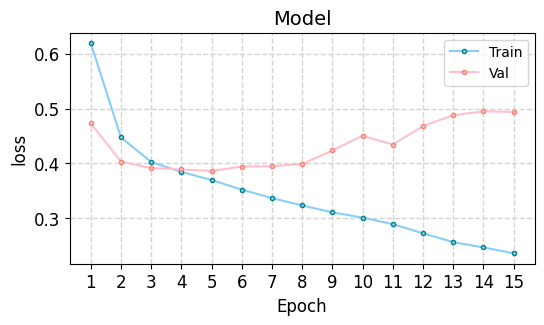

In [34]:
draw_pics(record, 'loss', img_save=False, show=True)

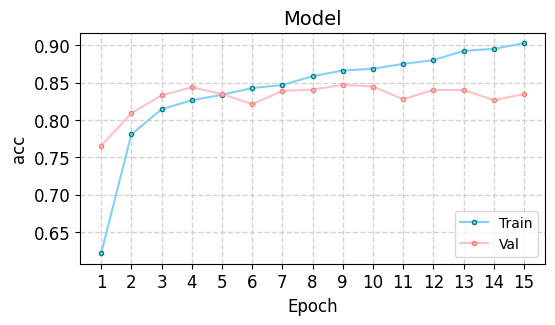

In [35]:
draw_pics(record, 'acc', img_save=False, show=True)

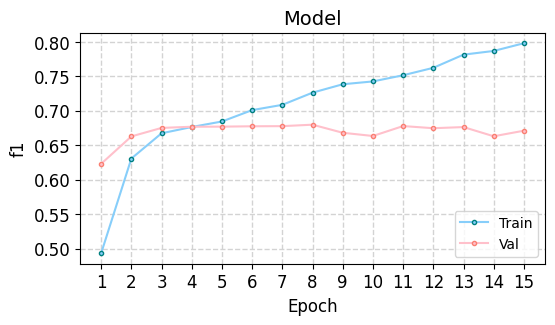

In [36]:
draw_pics(record, 'f1', img_save=False, show=True)

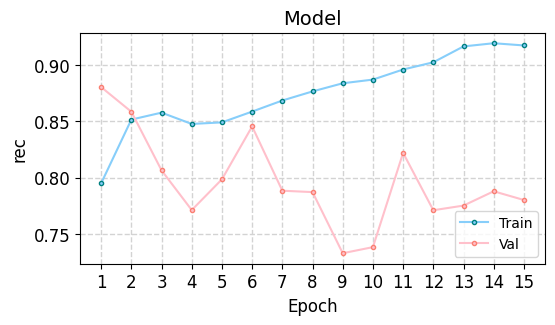

In [37]:
draw_pics(record, 'rec', img_save=False, show=True)

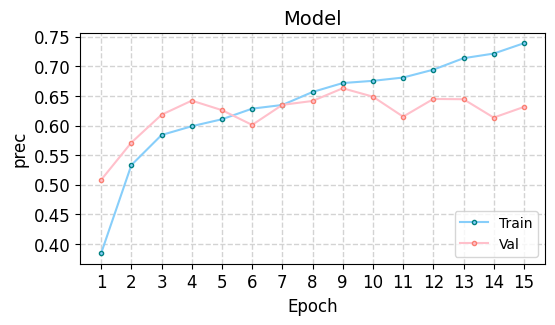

In [38]:
draw_pics(record, 'prec', img_save=False, show=True)

In [39]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_preds = []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
        head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids = [t.to(device) for t in data]
        headline = [head_ids, head_masks, head_token_type_ids]
        paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]

        # forward pass
        logits = model(headline)
        total_preds.append(get_pred(logits).item())
    
  return total_preds

In [40]:
total_preds = predict(test_loader, model)

In [41]:
len(total_preds)

18979

In [42]:
submission_df = pd.DataFrame()
submission_df = test_df
submission_df['LABEL'] = total_preds

In [43]:
def transform_class(class_):
  label = 0
  if class_ == 'clickbait':
    label = 1
  return label

In [44]:
submission_df['truthClass'] = submission_df['truthClass'].apply(transform_class)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(submission_df['truthClass'], submission_df['LABEL'])

0.8490436798566837

In [46]:
from sklearn.metrics import recall_score
recall_score(submission_df['truthClass'], submission_df['LABEL'])

0.8478405315614618

In [47]:
from sklearn.metrics import precision_score
precision_score(submission_df['truthClass'], submission_df['LABEL'])

0.6373626373626373

In [48]:
from sklearn.metrics import f1_score
f1_score(submission_df['truthClass'], submission_df['LABEL'])

0.7276874821785001

<Axes: >

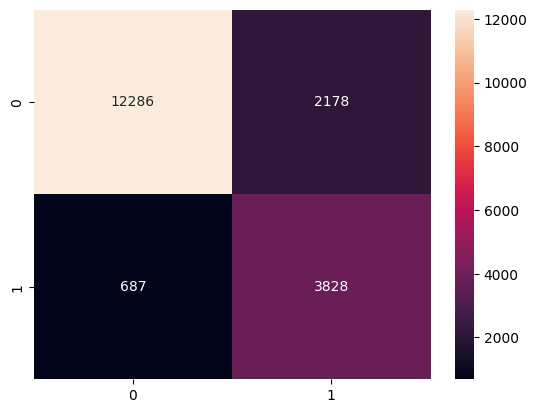

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(submission_df['truthClass'], submission_df['LABEL'])
sns.heatmap(cf_matrix, annot=True, fmt='.20g')

In [50]:
from sklearn.metrics import classification_report
target_names = ['non-clickbait', 'clickbait']
print(classification_report(submission_df['truthClass'], submission_df['LABEL'], target_names=target_names))

               precision    recall  f1-score   support

non-clickbait       0.95      0.85      0.90     14464
    clickbait       0.64      0.85      0.73      4515

     accuracy                           0.85     18979
    macro avg       0.79      0.85      0.81     18979
 weighted avg       0.87      0.85      0.86     18979



In [51]:
test_df['truthClass'].value_counts()

0    14464
1     4515
Name: truthClass, dtype: int64

In [52]:
submission_df['LABEL'].value_counts()

0    12973
1     6006
Name: LABEL, dtype: int64

In [53]:
model_ = load_checkpoint('./clickbait_acc.pt', model, device)
total_preds = predict(test_loader, model_)
submission_df_ = pd.DataFrame()
submission_df_ = test_df
submission_df_['LABEL'] = total_preds

Model loaded from <== ./clickbait_acc.pt


In [54]:
accuracy_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.8599504715738447

In [55]:
recall_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.772093023255814

In [56]:
precision_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.681524926686217

In [57]:
f1_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.72398753894081

<Axes: >

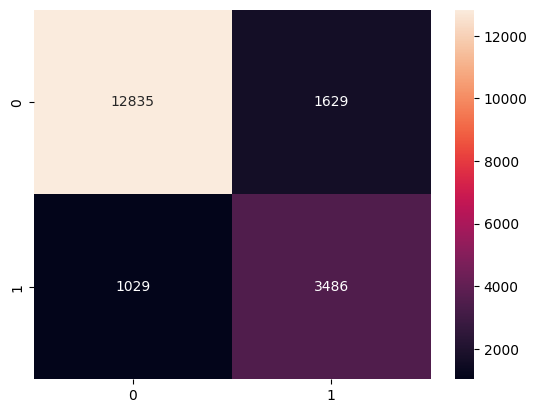

In [58]:
cf_matrix = confusion_matrix(submission_df_['truthClass'], submission_df_['LABEL'])
sns.heatmap(cf_matrix, annot=True, fmt='.20g')

In [59]:
print(classification_report(submission_df_['truthClass'], submission_df_['LABEL'], target_names=target_names))

               precision    recall  f1-score   support

non-clickbait       0.93      0.89      0.91     14464
    clickbait       0.68      0.77      0.72      4515

     accuracy                           0.86     18979
    macro avg       0.80      0.83      0.82     18979
 weighted avg       0.87      0.86      0.86     18979

